In [1]:
# load the data from the uproot files
import uproot
import warnings
import numpy as np
import awkward as ak
import vector
from coffea.nanoevents import NanoAODSchema, NanoEventsFactory

NanoAODSchema.warn_missing_crossrefs = False
warnings.filterwarnings("ignore", category=FutureWarning, module="coffea.*")

In [2]:
# variables into memory (takes ~1min)
file_dict = {
    "wjets": "preproc_uproot/z-prime-ttbar-data/wjets__nominal/file__0/part0.root",
    "ttbar_had": "preproc_uproot/z-prime-ttbar-data/ttbar_had__nominal/file__0/part0.root",
    "ttbar_lep": "preproc_uproot/z-prime-ttbar-data/ttbar_lep__nominal/file__0/part0.root",
    "ttbar_semilep": "preproc_uproot/z-prime-ttbar-data/ttbar_semilep__nominal/file__0/part0.root",
}

data = {}
for proc, file_path in file_dict.items():
    print(f"Processing {proc}...")
    data[proc] = {}
    events = NanoEventsFactory.from_root(
        f"{file_path}:Events", schemaclass=NanoAODSchema, delayed=False,
    ).events()

    print(events.Jet.fields)

    # require at least 2 jets and exaclty 1 muon
    events = events[ak.num(events.Jet, axis=1) >= 2]
    events = events[ak.num(events.Muon, axis=1) == 1]

    jets, muons = events.Jet, events.Muon

    # number of jets
    data[proc]["n_jet"] = ak.num(jets, axis=1).to_numpy()

    # leading and subleading jet mass
    data[proc]["leading_jet_mass"] = jets.mass[:, 0].to_numpy()
    data[proc]["subleading_jet_mass"] = jets.mass[:, 1].to_numpy()

    # scalar sum ST
    data[proc]["st"] = (
        ak.sum(jets.pt, axis=1) + ak.sum(muons.pt, axis=1)
    ).to_numpy()

    # leading and subleading jet b-tag score
    data[proc]["leading_jet_btag_score"] = jets.btagDeepB[:, 0].to_numpy()
    data[proc]["subleading_jet_btag_score"] = jets.btagDeepB[:, 1].to_numpy()

    # Sphericity tensor (only zz component)
    denominator = ak.sum(jets.px**2 + jets.py**2 + jets.pz**2, axis=1)
    S_zz = ak.sum(jets.pz * jets.pz, axis=1) / denominator
    data[proc]["S_zz"] = S_zz.to_numpy()

    # deltaR between muon and closest jet
    muon_in_pair, jet_in_pair = ak.unzip(ak.cartesian([muons, jets]))
    delta_r = muon_in_pair.deltaR(jet_in_pair)
    min_delta_r = ak.min(delta_r, axis=1)
    data[proc]["deltaR"] = min_delta_r.to_numpy()

    # transverse momentum of the muon w.r.t. the axis of the nearest jet (pt_rel)
    min_delta_r_indices = ak.argmin(delta_r, axis=1, keepdims=True)
    angle = muons.deltaangle(jet_in_pair[min_delta_r_indices])
    data[proc]["pt_rel"] = (muons.p * np.sin(angle)).to_numpy().flatten()

    # deltaR between muon and closest jet times the jet pt
    min_delta_r_indices = ak.argmin(delta_r, axis=1, keepdims=True)
    closest_jet_pt = jet_in_pair.pt[min_delta_r_indices]
    data[proc]["deltaR_times_pt"] = (min_delta_r * closest_jet_pt).to_numpy().flatten()


Processing wjets...
['btagDeepB', 'jetId', 'pt', 'eta', 'phi', 'mass']
Processing ttbar_had...
['btagDeepB', 'jetId', 'pt', 'eta', 'phi', 'mass']
Processing ttbar_lep...
['btagDeepB', 'jetId', 'pt', 'eta', 'phi', 'mass']
Processing ttbar_semilep...
['btagDeepB', 'jetId', 'pt', 'eta', 'phi', 'mass']


In [3]:
cd6 = {
    "blue": "#5790fc",
    "orange": "#f89c20",
    "red": "#e42536",
    "violet": "#964a8b",
    "gray": "#9c9ca1",
    "purple": "#7a21dd",
}

process_color_dict = {
    "wjets": cd6["blue"],
    "ttbar_had": cd6["red"],
    "ttbar_lep": cd6["orange"],
    "ttbar_semilep": cd6["purple"],
    "ttbar": cd6["red"],
}

model_color_dict = {}

In [4]:
processes = list(data.keys())
variables = list(data[processes[0]].keys())

data["ttbar"] = {}
for var in variables:
    data["ttbar"][var] = np.concatenate([data[p][var] for p in ["ttbar_had", "ttbar_lep", "ttbar_semilep"]])


Plotting n_jet
label: wjets, shape: (209983,), min: 2, max: 19
label: ttbar, shape: (9100771,), min: 2, max: 25


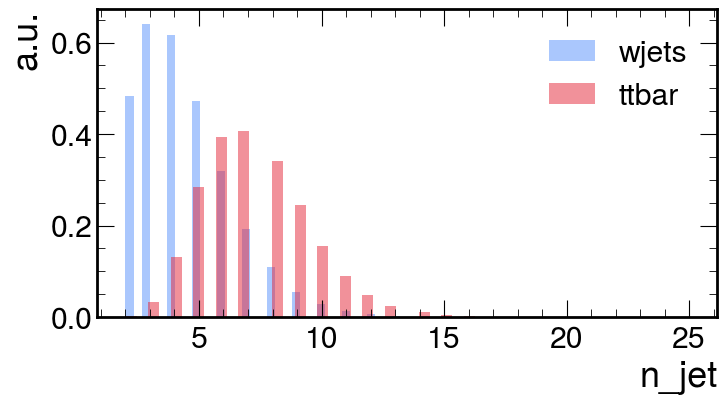

Plotting leading_jet_mass
label: wjets, shape: (209983,), min: -2.1576881408691406e-05, max: 156.75
label: ttbar, shape: (9100771,), min: -0.485107421875, max: 353.75


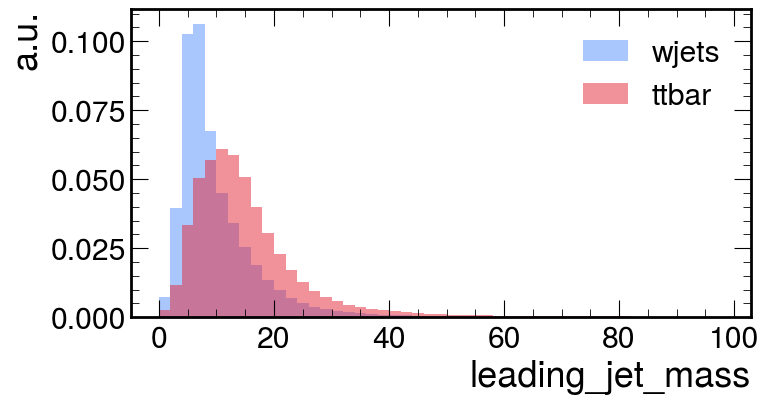

Plotting subleading_jet_mass
label: wjets, shape: (209983,), min: -1.0788440704345703e-05, max: 178.375
label: ttbar, shape: (9100771,), min: -0.26953125, max: 279.25


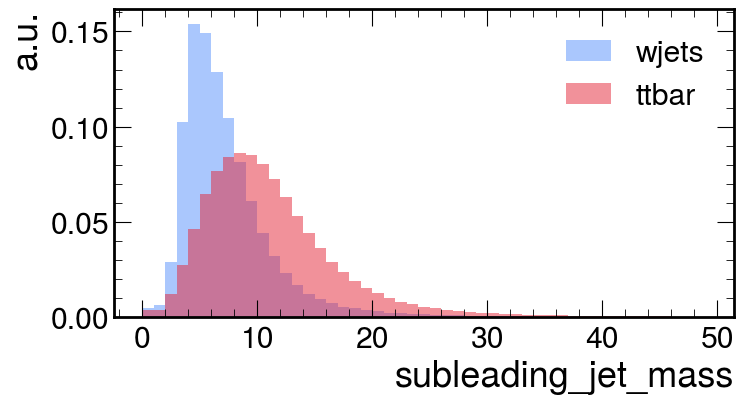

Plotting st
label: wjets, shape: (209983,), min: 55.74155044555664, max: 3635.639404296875
label: ttbar, shape: (9100771,), min: 102.36231231689453, max: 470374.46875


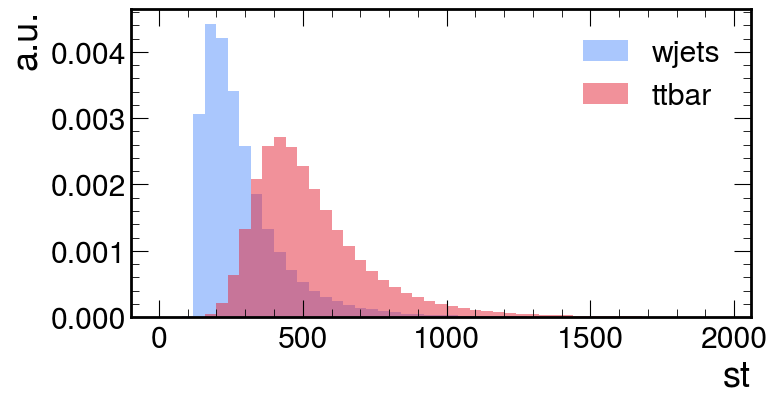

Plotting leading_jet_btag_score
label: wjets, shape: (209983,), min: -1.0, max: 0.99951171875
label: ttbar, shape: (9100771,), min: -1.0, max: 1.0


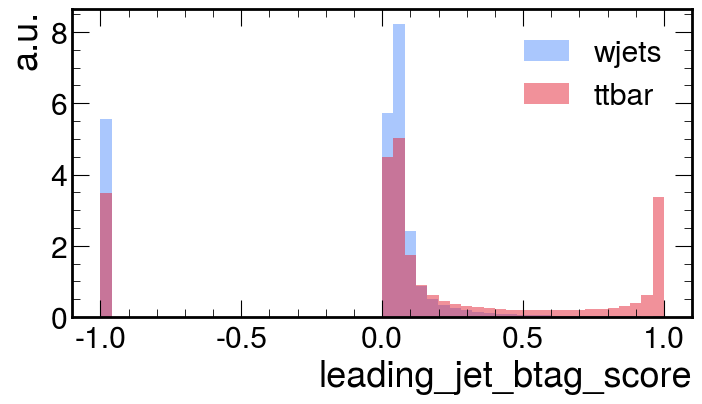

Plotting subleading_jet_btag_score
label: wjets, shape: (209983,), min: -1.0, max: 0.99951171875
label: ttbar, shape: (9100771,), min: -1.0, max: 1.0


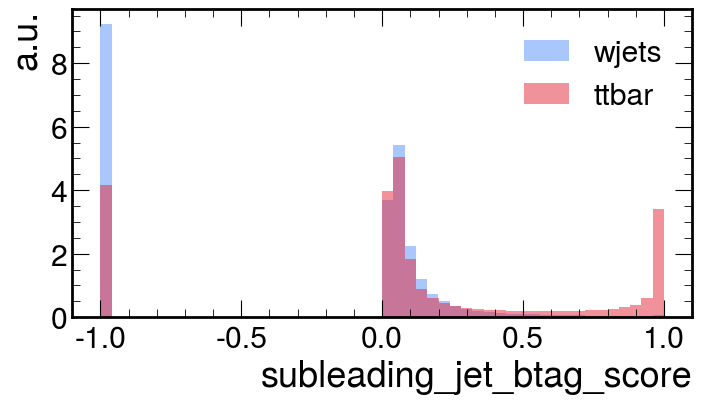

Plotting S_zz
label: wjets, shape: (209983,), min: 0.0002550473145674914, max: 0.999570369720459
label: ttbar, shape: (9100771,), min: 8.81735177244991e-05, max: 0.9996017813682556


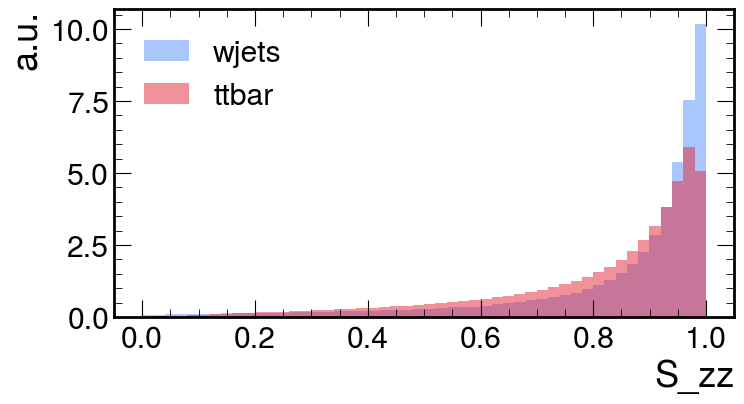

Plotting deltaR
label: wjets, shape: (209983,), min: 0.0, max: 5.327541351318359
label: ttbar, shape: (9100771,), min: 0.0, max: 4.41009521484375


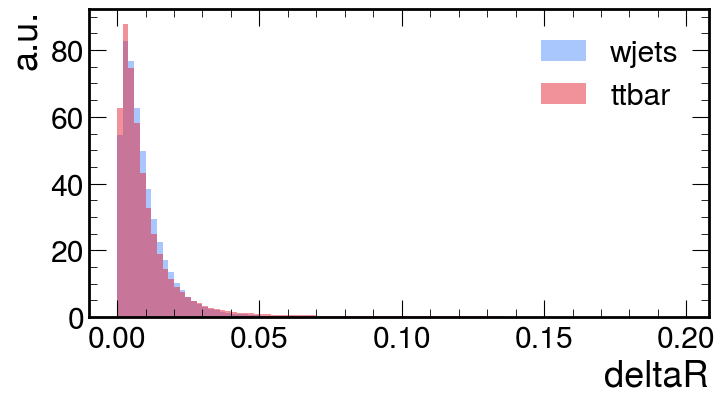

Plotting pt_rel
label: wjets, shape: (209983,), min: 0.0, max: 2518.23095703125
label: ttbar, shape: (9100771,), min: 0.0, max: 653225.5


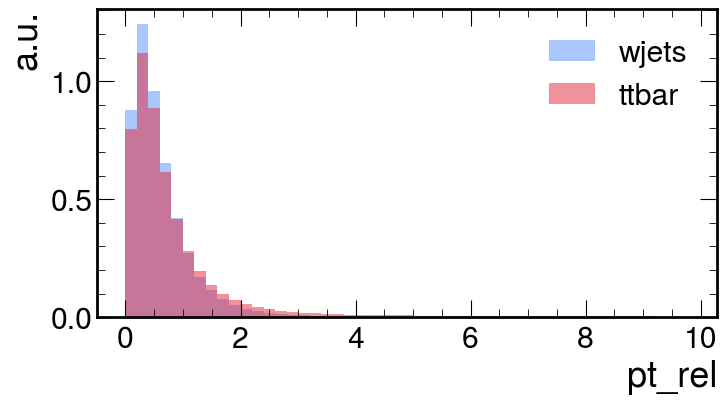

Plotting deltaR_times_pt
label: wjets, shape: (209983,), min: 0.0, max: 621.1012573242188
label: ttbar, shape: (9100771,), min: 0.0, max: 972.9558715820312


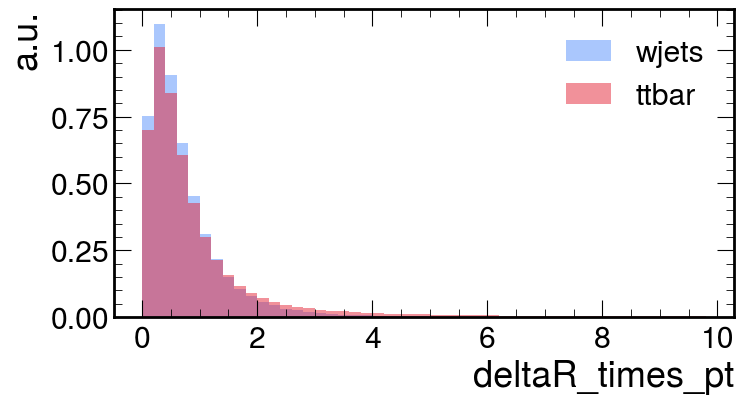

In [5]:
import importlib
from utils import drawing
importlib.reload(drawing)
draw = drawing.Draw(output_dir="output/plots/", interactive=True)
draw.process_color_dict = process_color_dict

binnings = {
    "n_jet": 50,
    "leading_jet_mass": range(0, 100, 2),
    "subleading_jet_mass": range(0, 50, 1),
    "st": range(0, 2000, 40),
    "leading_jet_btag_score": 50,
    "subleading_jet_btag_score": 50,
    "S_zz": 50,
    "deltaR": np.arange(0, 0.2, 0.002),
    "pt_rel": np.arange(0, 10, 0.2),
    "deltaR_times_pt": np.arange(0, 10, 0.2),
}

for var, bins in binnings.items():
    draw.plot_simple_hist(
        {p: data[p][var] for p in ["wjets", "ttbar"]},
        bins=bins,
        x_label=var,
    )



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

X_wjets = np.column_stack([data["wjets"][var] for var in variables]).astype(float)
X_ttbar = np.column_stack([data["ttbar"][var] for var in variables]).astype(float)

y_wjets = np.zeros_like(data["wjets"]["n_jet"], dtype=float)
y_ttbar = np.ones_like(data["ttbar"]["n_jet"], dtype=float)

X = np.concatenate([X_wjets, X_ttbar[:len(X_wjets)]], axis=0)  # tiny model, so we can omit most ttbar events to create a balanced dataset
y = np.concatenate([y_wjets, y_ttbar[:len(y_wjets)]], axis=0)
#  class_weights = {0: 1.0, 1: np.sum(y==0) / np.sum(y==1)}  # (also tested with imbalanced datasets and sample weights: minimal gain. hence omitted)

# X = StandardScaler().fit_transform(X) # works quite well w/o scaling.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
model = Sequential(
    [
        Dense(16, activation="relu", input_shape=(X_train.shape[1],)),
        Dense(8, activation="relu"),
        Dense(4, activation="relu"),
        Dense(1, activation="sigmoid"),
    ]
)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

/Users/linogerlach/Projects/IRIS-HEP/z-prime-ttbar-gradients/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Class weights: {0: 1.0, 1: 1.0}
Epoch 1/50
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 4s 779us/step - accuracy: 0.7893 - loss: 0.4979 - val_accuracy: 0.8769 - val_loss: 0.3160
Epoch 2/50
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 3s 723us/step - accuracy: 0.8733 - loss: 0.3295 - val_accuracy: 0.8710 - val_loss: 0.3148
Epoch 3/50
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 3s 704us/step - accuracy: 0.8737 - loss: 0.3111 - val_accuracy: 0.8745 - val_loss: 0.3061
Epoch 4/50
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 3s 766us/step - accuracy: 0.8745 - loss: 0.3077 - val_accuracy: 0.8791 - val_loss: 0.2925
Epoch 5/50
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 3s 788us/step - accuracy: 0.8838 - loss: 0.2820 - val_accuracy: 0.8922 - val_loss: 0.2700
Epoch 6/50
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 3s 726us/step - accuracy: 0.8960 - loss: 0.2542 - val_accuracy: 0.8991 - val_loss: 0.2546
Epoch 7/50
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 3s 782us/step - accuracy: 0.8967 - loss: 0.2715 - val_accuracy: 0.9033 - val_loss: 0.2414
Epoch 8/50
4200/4200 ━━━━━━━━━━━━━━━━━━━━ 3s

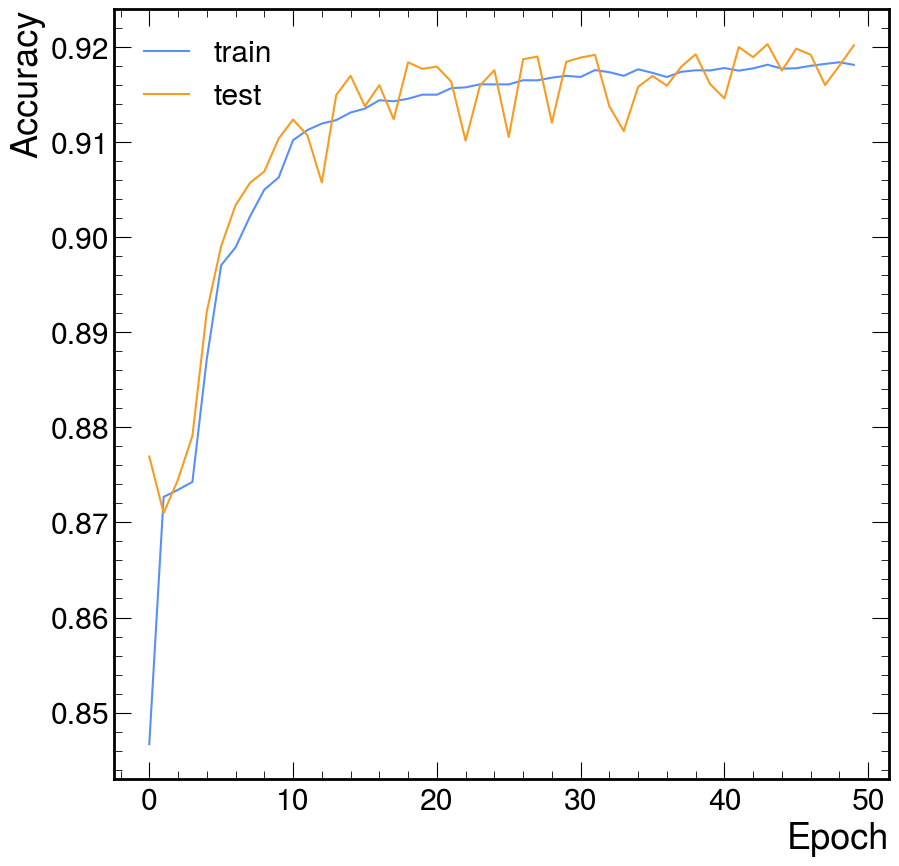

In [ ]:
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    verbose=1,
    # class_weight=class_weights,
)

import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [65]:
# print model scores for wjets and ttbar
wjets_score = model.predict(X_test[y_test==0], verbose=1, batch_size=2048)
ttbar_score = model.predict(X_test[y_test==1], verbose=1, batch_size=2048)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


np.mean(wjets_score): 0.09846480190753937
np.mean(ttbar_score): 0.8694511651992798


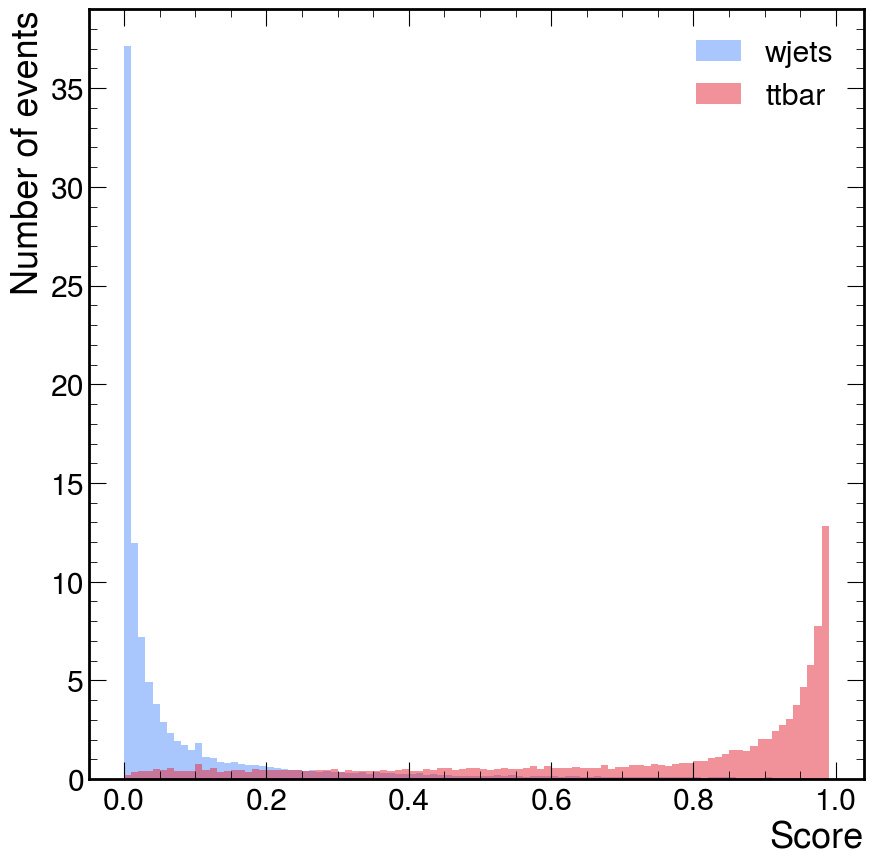

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,077 (12.02 KB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,052 (8.02 KB)

In [67]:
print(f"np.mean(wjets_score): {np.mean(wjets_score)}")
print(f"np.mean(ttbar_score): {np.mean(ttbar_score)}")
plt.hist(
    wjets_score,
    # bins=np.arange(0, 1, 0.01),
    # alpha=0.5,
    bins=np.arange(0, 1, 0.01),
    label="wjets",
    color=process_color_dict["wjets"],
    alpha=0.5,
    density=True,
)
plt.hist(
    ttbar_score,
    # bins=np.arange(0, 1, 0.01),
    # alpha=0.5,
    bins=np.arange(0, 1, 0.01),
    label="ttbar",
    color=process_color_dict["ttbar"],
    alpha=0.5,
    density=True,
)
plt.xlabel("Score")
plt.ylabel("Number of events")
plt.legend()
plt.show()

model.summary()